In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import torch.nn.functional as F
import torchvision
BATCH_SIZE = 256
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)), #resizing images so they work with the AlexNet architecture
    torchvision.transforms.RandomCrop((64,64)), ## crops a random 64x64 space to avoid the model overfitting the data
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70,70)),
    torchvision.transforms.CenterCrop((64,64)), # Now we center crop as we are not training the data
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_trans)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_trans)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

class_labels = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        
        self.dropout = nn.Dropout(0.3)
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.dropout(out) # dropout layer
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
model = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10)  # 4 blocks with 1 layer each
print(model)

# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

# Define the network, loss function, and optimizer
net = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

ResNet18(
  (dropout): Dropout(p=0.3, inplace=False)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Bat

In [5]:
# Lists for storing loss values and validation accuracy
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
num_epochs = 10
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total * 100  # Return accuracy as percentage

start_time = time.time()

# Training and validation loop
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    epoch_time_start = time.time()
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = accuracy(outputs, labels)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(running_loss / len(trainloader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)
    end_time = time.time()
    elapsed_time = end_time - start_time
    epoch_time = end_time - epoch_time_start
    print("==============================================================")
    print(f" | Epoch [{epoch+1}/{num_epochs}]")
    print(f" | Train Loss: {train_loss_list[-1]:.4f}       | Train Accuracy: {train_accuracy_list[-1]:.2f}%     | ")
    print(f" | Validation Loss: {val_loss_list[-1]:.4f}  | Validation Accuracy: {val_accuracy:.2f}% | ")
    print("==============================================================")
    print(f" | Training Time For This Epoch: {epoch_time:.2f} seconds")
    print("--------------------------------------------------------------")
    print(f" | Total Elapsed Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    print("==============================================================")
    print("")
    print("")
    

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

 | Epoch [1/10]
 | Train Loss: 1.4732       | Train Accuracy: 60.00%     | 
 | Validation Loss: 1.1967  | Validation Accuracy: 56.88% | 
 | Training Time For This Epoch: 131.66 seconds
--------------------------------------------------------------
 | Total Elapsed Time: 2m 12s


 | Epoch [2/10]
 | Train Loss: 0.9355       | Train Accuracy: 80.00%     | 
 | Validation Loss: 0.9087  | Validation Accuracy: 68.11% | 
 | Training Time For This Epoch: 127.07 seconds
--------------------------------------------------------------
 | Total Elapsed Time: 4m 19s


 | Epoch [3/10]
 | Train Loss: 0.6947       | Train Accuracy: 75.00%     | 
 | Validation Loss: 0.7361  | Validation Accuracy: 74.24% | 
 | Training Time For This Epoch: 126.79 seconds
--------------------------------------------------------------
 | Total Elapsed Time: 6m 26s


 | Epoch [4/10]
 | Train Loss: 0.5462       | Train Accuracy: 86.25%     | 
 | Validation Loss: 0.6467  | Validation Accuracy: 78.02% | 
 | Training Time For Th

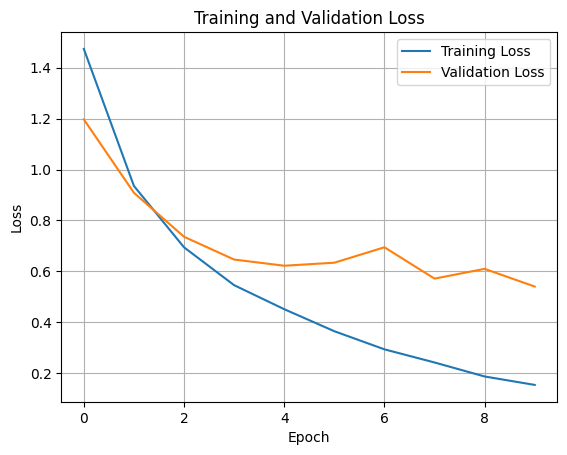

In [6]:
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

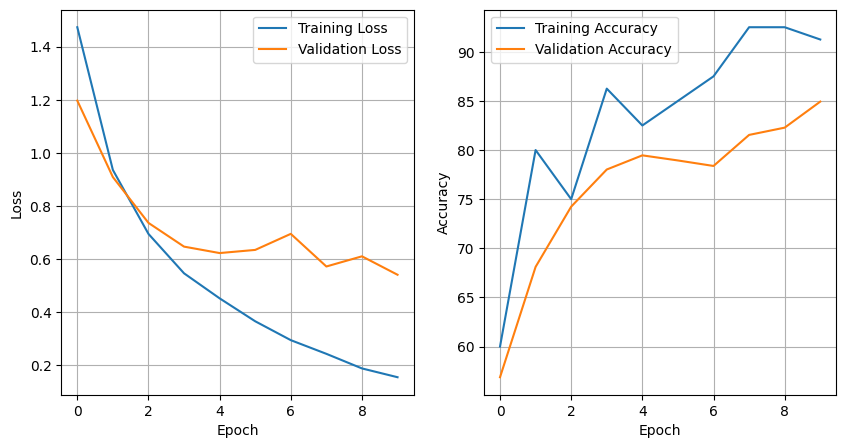

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()